In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
from conkit.misc import bandwidth

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['text.usetex'] = True
rand_seed = 100

In [2]:
def make_data_normal(data_count=100):
    np.random.seed(rand_seed)
    x = np.random.normal(0, 1, data_count)
    dist = lambda z: stats.norm(0, 1).pdf(z)
    return x, dist

def make_data_binormal(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.normal(-1, 2, int(data_count * alpha)),
        np.random.normal(5, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.norm(-1, 2).pdf(z) + (1 - alpha) * stats.norm(5, 1).pdf(z)
    return x, dist

def make_data_exp(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.exponential(1, int(data_count * alpha)),
        np.random.exponential(1, int(data_count * (1 - alpha))) + 1
    ])
    dist = lambda z: alpha * stats.expon(0).pdf(z) + (1 - alpha) * stats.expon(1).pdf(z)
    return x, dist

def make_data_uniform(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.uniform(-1, 1, int(data_count * alpha)),
        np.random.uniform(0, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.uniform(-1, 1).pdf(z) + (1 - alpha) * stats.uniform(0, 1).pdf(z)
    return x, dist

x_norm, dist_norm = make_data_normal()
x_binorm, dist_binorm = make_data_binormal()
x_exp, dist_exp = make_data_exp()
x_uni, dist_exp = make_data_uniform()

In [3]:
def _select_sigma(x):
    normalizer = 1.349
    iqr = (stats.scoreatpercentile(x, 75) - stats.scoreatpercentile(x, 25)) / normalizer
    std_dev = np.std(x, axis=0, ddof=1)
    return np.minimum(std_dev, iqr) if iqr > 0 else std_dev

def bw_scott(data: np.ndarray):
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 1.059 * std_dev * n ** (-0.2)

def bw_silverman(data: np.ndarray):
    sigma = _select_sigma(data)
    n = len(data)
    return 0.9 * sigma * n ** (-0.2)

def bw_mlcv(data: np.ndarray, k):
    n = len(data)
    x = np.linspace(np.min(data), np.max(data), n)
    def mlcv(h):
        fj = np.zeros(n)
        for j in range(n):
            for i in range(n):
                if i == j: continue
                fj[j] += k((x[j] - data[i]) / h)
            fj[j] /= (n - 1) * h
        return -np.mean(np.log(fj[fj > 0]))
    h = optimize.minimize(mlcv, 1)
    if np.abs(h.x[0]) >= 100: # Fail fallback
        return bw_scott(data)
    return h.x[0]

def bw_amise(data: np.ndarray):
    # Using the AmiseBW from ConKit for AMISE.
    return bandwidth.AmiseBW((1e4 * data[:,None]).astype(np.int64)).bandwidth / 1e4

In [4]:
def kernel(k: str):
    """Kernel Functions.
    Ref: https://en.wikipedia.org/wiki/Kernel_(statistics)

    Args:
        k (str): Kernel name. Can be one of ['gaussian', 'epanechnikov', 'cosine', 'linear'.]
    """
    
    if k not in ['gaussian', 'epanechnikov', 'cosine', 'linear']:
        raise ValueError('Unknown kernel.')

    def bounded(f):
        def _f(x):
            return f(x) if np.abs(x) <= 1 else 0
        return _f

    if k == 'gaussian':
        return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)
    elif k == 'epanechnikov':
        return bounded(lambda u: (3 / 4 * (1 - u * u)))
    elif k =='cosine':
        return bounded(lambda u: np.pi / 4 * np.cos(np.pi / 2 * u))
    elif k == 'linear':
        return bounded(lambda u: 1 - np.abs(u))

def kde(data, k=None, h=None, x=None):
    """Kernel Density Estimation.

    Args:
        data (np.ndarray): Data.
        k (function): Kernel function.
        h (float): Bandwidth.
        x (np.ndarray, optional): Grid. Defaults to None.

    Returns:
        np.ndarray: Kernel density estimation.
    """
    if x is None:
        x = np.linspace(np.min(data), np.max(data), 1000)
    if h is None:
        h = bw_silverman(data)
    if k is None:
        k = kernel('gaussian')
    n = len(data)
    kde = np.zeros_like(x)
    for j in range(len(x)):
        for i in range(n):
            kde[j] += k((x[j] - data[i]) / h)
        kde[j] /= n * h
    return kde

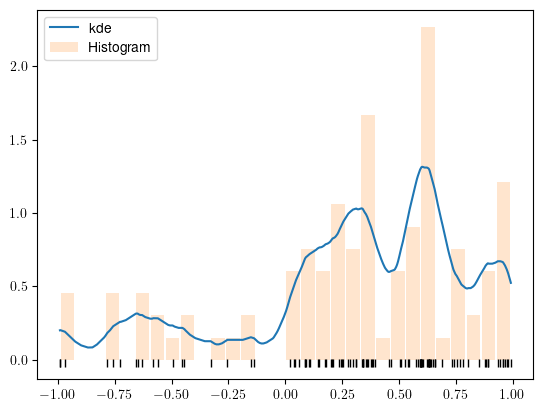

In [5]:
# plot x_norm and kde
x = np.linspace(np.min(x_uni), np.max(x_uni), 1000)
kde_norm = kde(x_uni, kernel('linear'), h=bw_silverman(x_uni), x=x)
plt.plot(x, kde_norm, label='kde')
plt.hist(x_uni, density=True, alpha=0.2, label='Histogram', bins=30, rwidth=0.9)
plt.plot(x_uni, np.full_like(x_uni, -0.02), '|k', markeredgewidth=1)
plt.legend()
plt.show()

/Users/billchen/opt/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/billchen/opt/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/billchen/opt/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/billchen/opt/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/billchen/opt/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/billchen/opt/anaconda3/envs/torch

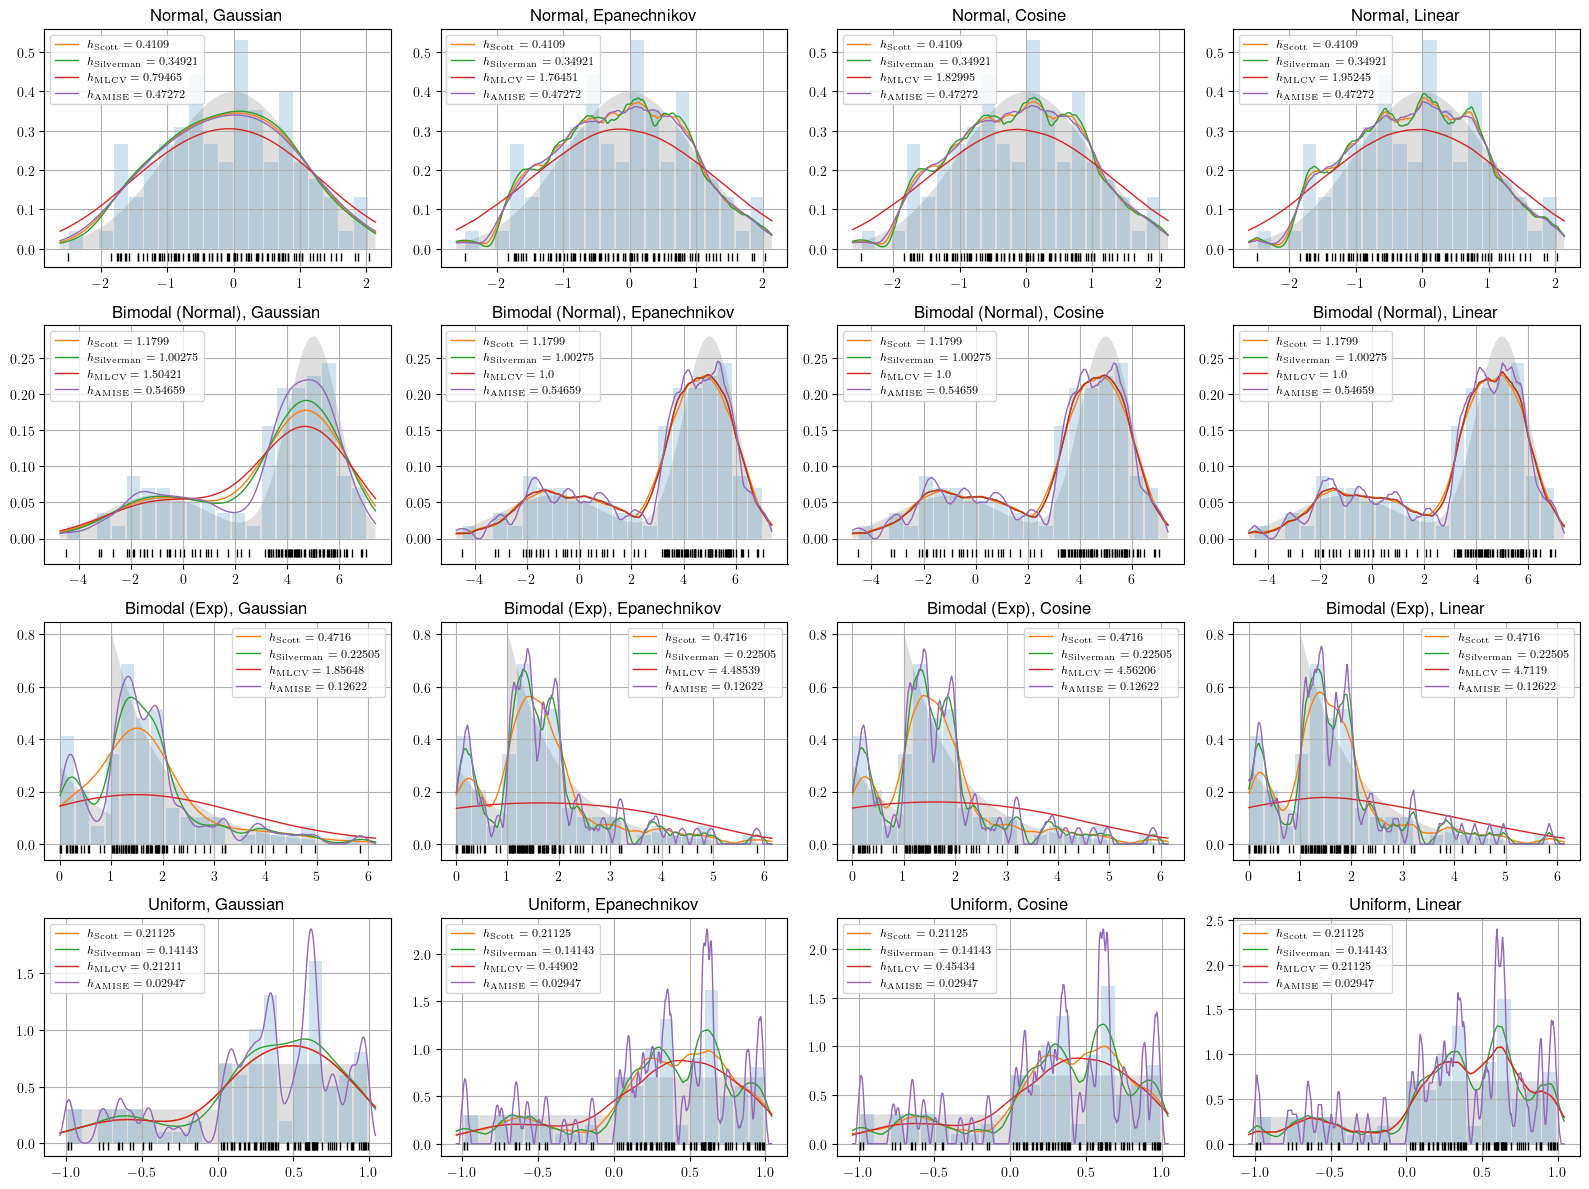

In [6]:
data = [
    ('Normal', make_data_normal),
    ('Bimodal (Normal)', make_data_binormal),
    ('Bimodal (Exp)', make_data_exp),
    ('Uniform', make_data_uniform)
]
kernels = [
    ('Gaussian', kernel('gaussian')),
    ('Epanechnikov', kernel('epanechnikov')),
    ('Cosine', kernel('cosine')),
    ('Linear', kernel('linear'))
]
bw_algorithms = [
    ('Scott', bw_scott),
    ('Silverman', bw_silverman),
    ('MLCV', bw_mlcv),
    ('AMISE', bw_amise)
]
mses = []

def run_kde(ax, data, kernel):
    x, dist = data[1]()
    x_plot = np.linspace(np.min(x) * 1.05, np.max(x) * 1.05, 1000)
    ax.grid(True)
    ax.fill_between(x_plot, dist(x_plot), fc='silver', alpha=0.5)
    ax.plot(x, np.full_like(x, -0.02), '|k', markeredgewidth=1)
    ax.hist(x, density=True, alpha=0.2, bins=20, rwidth=0.9)
    for bw in bw_algorithms:
        if bw[0] == 'MLCV':
            h = bw[1](x, kernel[1])
        else:
            h = bw[1](x)
        x_kde = kde(x, kernel[1], h=h, x=x_plot)
        mse = np.mean((dist(x_plot) - x_kde) ** 2)
        mses.append({
            'data': data[0],
            'kernel': kernel[0],
            'bw_algorithm': bw[0],
            'h': round(h, 5),
            'mse': round(mse * 1000, 5),
        })
        ax.plot(x_plot, x_kde, linewidth=1, label='$h_{\mathrm{' + bw[0] + '}} = ' + str(round(h, 5)) + '$')
    ax.legend(loc='best', fontsize='small')
    ax.set_title(f'{data[0]}, {kernel[0]}')

fig, axs = plt.subplots(len(data), len(kernels), figsize=(16, 12))
for i, d in enumerate(data):
    for j, k in enumerate(kernels):
        run_kde(axs[i, j], d, k)
    for bw in bw_algorithms:
        avg_h = np.mean([m['h'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        avg_mse = np.mean([m['mse'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        mses.append({
            'data': d[0],
            'kernel': '-',
            'bw_algorithm': bw[0],
            'h': round(avg_h, 5),
            'mse': round(avg_mse, 5),
        })

fig.tight_layout()
fig.savefig('./kde.svg')
pd.DataFrame(mses).to_csv('./statistics.csv', index=False)